# Coding your own RNN

Using this pre-filled notebook, we will code our own RNN for sentence classification. For now, we'll keep using IMDB, as the goal of this part is to understand how an RNN works.

Unlike our previous lab, we will also learn the embedding layer. Which means we need to deal with vocabulary by ourselves.

In [1]:
!pip install datasets
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 5.6 MB/s eta 0:00:00


## Dataset
We load the dataset and split the training set in a stratified train/validation set.

In [2]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

((20000, 2), (5000, 2), (25000, 2))

## Vocabulary (1 point)

**\[1 point\]** Build your own vocabulary. The [example provided in torchtext documentation](https://pytorch.org/text/stable/vocab.html#id1) might be of help.
* Don't forge to setup the `min_freq` parameter to not include unfrequent noise.
* You will need a tokenizer. Reuse the `basic_english` one from the our previous lab.
* For an RNN we need two special tokens: `<unk>`, for unknown words, and `<pad>` for padding.

In [45]:
from collections import Counter, OrderedDict
tokenizer = get_tokenizer("basic_english", language="en")

words = [word for sentence in train_df['text'] for word in tokenizer(sentence)]
counter = Counter(words)
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)
unk_token = '<unk>'
pad_token = '<pad>'
default_index = -1
vocabulary = vocab(ordered_dict=ordered_dict, specials=[unk_token, pad_token], min_freq=3)
vocabulary.set_default_index(default_index)
vocabulary.set_default_index(vocabulary[unk_token])

In [46]:
vocabulary[pad_token]

1

## Vectorize and batch the input (3 points)

As seen in class, our model should take one-hot encoded vectors corresponding to the each token vocabulary id. However, computing a vector x matrix multiplication for every input is unnecessarily costly. Multiplying a one-hot vector with a matrix is the equivalent of taking one row of the matrix. In pyTorch, we provide ids for each token which will be used as input to an `nn.Embedding` layer. The id is simply the row in the embedding matrix.

**\[1 point\]** Fill the `vectorize_text` function returning a 1D torch tensor of `torch.long` for each input text.

In [47]:
def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    tokens = tokenizer(text)
    res = []
    for token in tokens:
        res.append(vocabulary[token])
    return torch.tensor(res, dtype=torch.long)

In [48]:
text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)

Check the function is working correctly, especially it should return the right special id for unknown words.

In [49]:
text_pipeline("Some text I am thinking about... ragafqfa")

tensor([  56, 3160,   13,  244,  526,   50,    3,    3,    3,    0])

In [50]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

To speed up the training process, we turn the inputs into batches, as we did last time. For batches to work, every line must have the same lengths. Last time, it was implicit as only a vector (the average of all embeddings) was provided. This time, every line has the length of a different review.

To go around this problem, we use padding. So every line within a batch is padded to the length of its longest element.

* **\[1 point\]** Fill the data generator function.
* **\[1 point\]** On which side should you pad and why?

In [71]:
def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    for i in range(0, len(X) - batch_size, batch_size):
        max_length = 0
        for j in range(i, i + batch_size):
            if X[j].size()[0] > max_length:
              max_length = X[j].size()[0]
        for j in range(i, i + batch_size):
            pad = max_length - X[j].size()[0]
            pad_tensor = torch.full((pad,), pad_id)
            X[j] = torch.cat((pad_tensor, X[j]))
            
        yield (torch.stack(X[i:i+batch_size]), torch.tensor(y[i:i+batch_size], dtype=torch.long))

In [72]:
train_gen = lambda: data_generator(X_train, y_train, vocabulary[pad_token])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary[pad_token])
test_gen = lambda: data_generator(X_test, y_test, vocabulary[pad_token])

## Classifier (3 points)

**\[3 points\]** Code your own RNN. Fill the `RNN` class correctly. Remember, an RNN has 3 elements.
* An embedding layer to turn one-hot vectors into dense vectors.
* A linear layer which takes the concatenation of the current embedding and hidden layer and send it to the hidden layer of our next step.
  * `embedding_size + hidden_size -> hidden_size`
* A linear layer which takes the concatenation of the current embedding and hidden layer and send it to the output.
  * `embedding_size + hidden_size -> 1`
* The provided `init_hidden` function sho

In [73]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.hidden = nn.Linear(embedding_size, hidden_size)
        self.previous = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        
        # Concatenate the embedded input and hidden state
        current = self.hidden(embedded)

        # Pass the concatenated tensor through the linear layer
        previous = self.previous(hidden)

        # Pass the concatenated tensor through the output layer
        output = self.output(torch.tanh(current + previous))

        return output, hidden

    def init_hidden(self, batch_size):
        # Initialize hidden state with zeros
        hidden = torch.zeros(batch_size, self.hidden_size)
        return hidden

## Training (2 points)

Training is a bit different than usual. We will need to sequentially (but in "batch parallel") go through an input, keeping track of the hidden layer, and use the last output as prediction.

**\[2 point\]** Code the training loop.
* Note that for each batch, you need to loop through the whole input and use the output of the last token as input to your criterion.
* Keep the best model evaluated on the validation set.
* Plot the training and validation losses.
* Training will take some time (~30 min on a T4 GPU). Make sure your results appear in the notebook.

In [83]:
import matplotlib.pyplot as plt

def train(model, criterion, optimizer, train_loader, valid_loader, num_epochs):
    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')
    best_model = None

    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0.0
        t_batch = 0

        for inputs, targets in train_loader():
            optimizer.zero_grad()

            hidden = model.init_hidden(inputs.size(1))
            outputs, _ = model(inputs, hidden)

            # Use the output of the last token as the prediction
            last_output = outputs[:,-1,:]
            targets = targets.unsqueeze(-1).float()
            loss = criterion(last_output, targets)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            t_batch +=1

        # Calculate average training loss for the epoch
        train_loss /= t_batch
        train_losses.append(train_loss)

        model.eval()
        valid_loss = 0.0
        v_batch = 0
        with torch.no_grad():
            for inputs, targets in valid_loader():
                hidden = model.init_hidden(inputs.size(1))
                outputs, _ = model(inputs, hidden)

                last_output = outputs[:,-1]
                targets = targets.view(-1,1).float()
                loss = criterion(last_output, targets)

                valid_loss += loss.item()
                v_batch += 1

        # Calculate average validation loss for the epoch
        valid_loss /= v_batch
        valid_losses.append(valid_loss)

        # Check if current model has the best validation loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = model.state_dict()

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, "
              f"Valid Loss: {valid_loss:.4f}")

    # Load the best model
    model.load_state_dict(best_model)

    # Plot the training and validation losses
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return model


In [84]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [85]:
n_embedding = 32
n_hidden = 64
model = RNN(len(vocabulary.get_itos()), n_embedding, n_hidden).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

## Evaluation (1 point)

* **\[1 point\]** Compute the accuracy for all 3 splits.

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10: Train Loss: 0.6847, Valid Loss: 0.6772
Epoch 2/10: Train Loss: 0.6761, Valid Loss: 0.6739
Epoch 3/10: Train Loss: 0.6732, Valid Loss: 0.6730
Epoch 4/10: Train Loss: 0.6707, Valid Loss: 0.6724
Epoch 5/10: Train Loss: 0.6688, Valid Loss: 0.6725
Epoch 6/10: Train Loss: 0.6669, Valid Loss: 0.6728
Epoch 7/10: Train Loss: 0.6651, Valid Loss: 0.6735
Epoch 8/10: Train Loss: 0.6637, Valid Loss: 0.6750
Epoch 9/10: Train Loss: 0.6625, Valid Loss: 0.6736
Epoch 10/10: Train Loss: 0.6608, Valid Loss: 0.6761


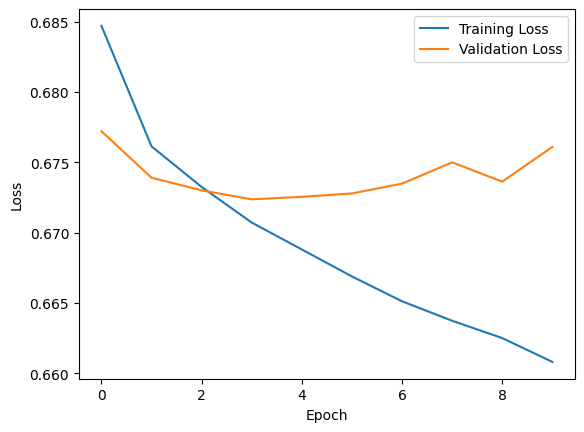

In [86]:
trained = train(model, criterion,optimizer, train_gen, valid_gen, 10)

In [89]:
# Your code
# Note that we need to use a sigmoid on the output now.
def evaluate(model: nn.Module, dataloader: Generator[Tuple[torch.Tensor, torch.Tensor], None, None]) -> float:
    """
    Function evaluating the model on dataset.
    """
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            targets = targets.view(-1,1).float()
            hidden = model.init_hidden(inputs.size(1))
            outputs, _ = model(inputs, hidden)
            predicted = torch.round(torch.sigmoid(outputs))
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return correct / total
def accuracy(model: nn.Module) -> None:
    """
    Print the accuracy of the model for the 3 dataset (train, val, test) ordered
    """
    with torch.no_grad():
        train_accuracy = evaluate(model, train_gen())
        val_accuracy = evaluate(model, valid_gen())
        test_accuracy = evaluate(model, test_gen())
    print(train_accuracy, val_accuracy, test_accuracy)

accuracy(trained)

RuntimeError: ignored